In [1]:
import spams
import numpy as np
import sys
sys.path.append('../')
from src.funcs.regularizer import TreeOG, NatOG
from scipy.sparse import csc_matrix
from src.utils import gen_tree
import argparse
def get_config():
    parser = argparse.ArgumentParser()
    # IPG solver configurations
    parser.add_argument("--ipg_save_log", default=True, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="whether save the log of the ipg solver.")
    parser.add_argument("--exact_pg_computation", default=False, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="Mimic to the exact computation of the proximal operator.") 
    parser.add_argument("--exact_pg_computation_tol", type=float, default=1e-15, help="Deisred error tolerance.")                                                                      

    parser.add_argument("--ipg_do_linesearch", default=True, type=lambda x: (str(x).lower()
                        in ['true', '1', 'yes']), help="Whether do linesearch in the projected gradient ascent.")
    parser.add_argument("--ipg_linesearch_eta", type=float, default=1e-4, help="eta of the linesearch.")
    parser.add_argument("--ipg_linesearch_xi", type=float, default=0.8, help="xi of the linesearch.")
    parser.add_argument("--ipg_linesearch_beta", type=float, default=1.2, help="beta of the linesearch.")
    parser.add_argument("--ipg_linesearch_limits", type=int, default=100, help="max attempts of the linesearch.")
    
    parser.add_argument("--ipg_strategy", type=str, default="diminishing", choices=["diminishing"], 
        help="Strategy to inexactly evaluate the proximal operator.\ndiminishing: c * np.log(k+1) / k**delta")
    parser.add_argument("--ipg_diminishing_c", type=float, default=1, help="c of c * np.log(k+1) / k**delta")
    parser.add_argument("--ipg_diminishing_delta", type=float, default=2, help="delta of c * np.log(k+1) / k**delta")
    config = parser.parse_args(args=[])
    return config

config = get_config()

# Binary Tree

In [2]:
p = 15
np.random.seed(0)
xk = np.random.randn(p, 1)
dk = np.random.randn(p, 1)
alphak = 1.0

# tree
nodes_list=[[i] for i in range(15)]
nodes_relation_dict={0:[1,8], 
                     1:[2,5], 2:[3,4], 5:[6,7], 
                     8:[9,12],9:[10, 11], 12:[13,14]}   
penalty = 0.1                     

## Full Tree

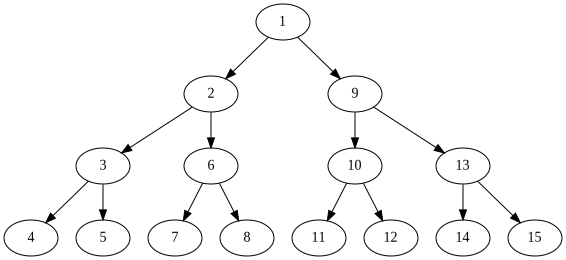

In [4]:
weights = np.ones((15,))
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=None)
dot.attr(bgcolor='transparent', ratio="compress")
for i in range(15):
    dot.node(f'{i}', f'{i+1}')
dot.render(filename='btree', directory='./graphviz', cleanup=True, format='pdf')
dot
dot 

## Pattern 1

G_0: [0, 1, 8, 2, 5, 9, 12, 3, 4, 6, 7, 10, 11, 13, 14] penalty: 0.1
G_1: [1, 2, 5, 3, 4, 6, 7] penalty: 0.1
G_2: [2, 3, 4] penalty: 10.0
G_3: [3] penalty: 0.1
G_4: [4] penalty: 0.1
G_5: [5, 6, 7] penalty: 0.1
G_6: [6] penalty: 0.1
G_7: [7] penalty: 0.1
G_8: [8, 9, 12, 10, 11, 13, 14] penalty: 0.1
G_9: [9, 10, 11] penalty: 0.1
G_10: [10] penalty: 0.1
G_11: [11] penalty: 0.1
G_12: [12, 13, 14] penalty: 10.0
G_13: [13] penalty: 0.1
G_14: [14] penalty: 0.1
=== spams sol ===
spams_sol [[ 1.39008802 -1.01123577  0.          0.          0.          1.37714605
   0.17171136 -0.80038822  0.59794682 -1.67596089  1.35076084  1.17957815
   0.          0.          0.        ]] 
spams_nnz 9 spams_nz 6
=== my sol===
mysol [[ 1.39072569 -1.01325075  0.          0.          0.          1.37992396
   0.1719737  -0.8019187   0.59849561 -1.67752204  1.35197389  1.18063175
   0.          0.          0.        ]] 
mynnz 9 mynz 6
sol diff 0.0044625825583911845


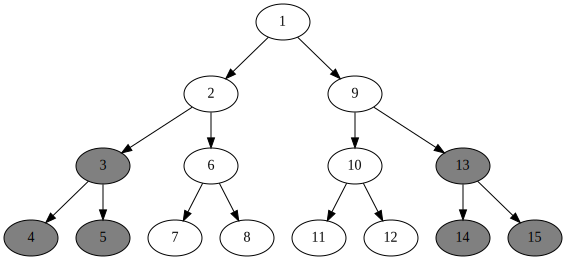

In [5]:
weights = np.ones((15,))
for i in [2,12]:
    weights[i] = 100  
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])
rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)

spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='btree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='btree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [2,3,4,12,13,14]:
    dot.node(f'{i}', f'{i}', style='filled', fillcolor='grey')
for i in range(15):
    dot.node(f'{i}', f'{i+1}')
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree_rm2sub', directory='./graphviz', cleanup=True, format='pdf')
dot    

## Pattern 2

G_0: [0, 1, 8, 2, 5, 9, 12, 3, 4, 6, 7, 10, 11, 13, 14] penalty: 0.1
G_1: [1, 2, 5, 3, 4, 6, 7] penalty: 10.0
G_2: [2, 3, 4] penalty: 10.0
G_3: [3] penalty: 10.0
G_4: [4] penalty: 10.0
G_5: [5, 6, 7] penalty: 10.0
G_6: [6] penalty: 10.0
G_7: [7] penalty: 10.0
G_8: [8, 9, 12, 10, 11, 13, 14] penalty: 0.1
G_9: [9, 10, 11] penalty: 0.1
G_10: [10] penalty: 0.1
G_11: [11] penalty: 0.1
G_12: [12, 13, 14] penalty: 0.1
G_13: [13] penalty: 0.1
G_14: [14] penalty: 0.1
=== spams sol ===
spams_sol [[ 1.38875654  0.          0.          0.          0.          0.
   0.          0.          0.60111708 -1.68484668  1.35792246  1.18583217
   0.84422437 -1.16730746 -0.82399084]] 
spams_nnz 8 spams_nz 7
=== my sol===
mysol [[ 1.38936454  0.          0.          0.          0.          0.
   0.          0.          0.60138025 -1.68558431  1.35851696  1.18635133
   0.84459398 -1.16781851 -0.82435158]] 
mynnz 8 mynz 7
sol diff 0.0014607914077914657


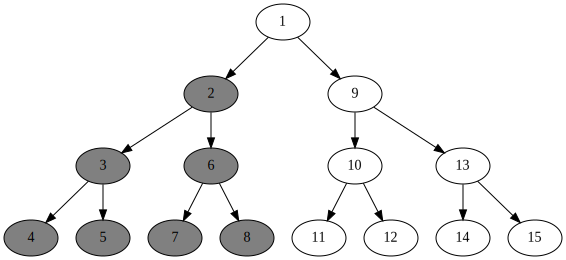

In [6]:
weights = np.ones((15,))
for i in [1,2,3,4,5,6,7]:
    weights[i] = 100  
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])
rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)

spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='btree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='btree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [1,2,3,4,5,6,7]:
    dot.node(f'{i}', f'{i}', style='filled', fillcolor='grey')
for i in range(15):
    dot.node(f'{i}', f'{i+1}')    
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree_rmleftsub', directory='./graphviz', cleanup=True, format='pdf')
dot    

## Pattern 3

G_0: [0, 1, 8, 2, 5, 9, 12, 3, 4, 6, 7, 10, 11, 13, 14] penalty: 0.1
G_1: [1, 2, 5, 3, 4, 6, 7] penalty: 0.1
G_2: [2, 3, 4] penalty: 0.1
G_3: [3] penalty: 10.0
G_4: [4] penalty: 10.0
G_5: [5, 6, 7] penalty: 0.1
G_6: [6] penalty: 10.0
G_7: [7] penalty: 10.0
G_8: [8, 9, 12, 10, 11, 13, 14] penalty: 0.1
G_9: [9, 10, 11] penalty: 0.1
G_10: [10] penalty: 10.0
G_11: [11] penalty: 10.0
G_12: [12, 13, 14] penalty: 0.1
G_13: [13] penalty: 10.0
G_14: [14] penalty: 10.0
=== spams sol ===
spams_sol [[ 1.38514554 -1.00966269  1.0004093   0.          0.          1.36204544
   0.          0.          0.58862953 -1.62062359  0.          0.
   0.78142461  0.          0.        ]] 
spams_nnz 7 spams_nz 8
=== my sol===
mysol [[ 1.38688868 -1.01141135  0.99811423  0.          0.          1.36334015
   0.          0.          0.58982186 -1.62160564  0.          0.
   0.77964872  0.          0.        ]] 
mynnz 7 mynz 8
sol diff 0.00431043545494864


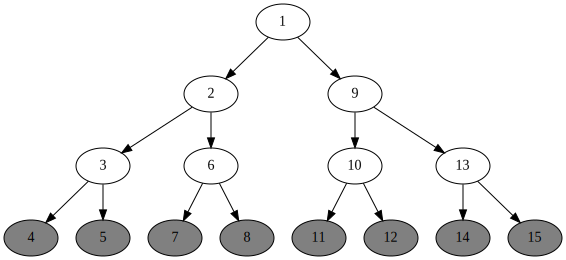

In [7]:
weights = np.ones((15,))
for i in [3,4,6,7,10,11,13,14]:
    weights[i] = 100            
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])
rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)
spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='btree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='btree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [3,4,6,7,10,11,13,14]:
    dot.node(f'{i}', f'{i}', style='filled', fillcolor='grey')
for i in range(15):
    dot.node(f'{i}', f'{i+1}')
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree_rml3', directory='./graphviz', cleanup=True, format='pdf')
dot

## Pattern 4

G_0: [0, 1, 8, 2, 5, 9, 12, 3, 4, 6, 7, 10, 11, 13, 14] penalty: 0.1
G_1: [1, 2, 5, 3, 4, 6, 7] penalty: 0.1
G_2: [2, 3, 4] penalty: 10.0
G_3: [3] penalty: 0.1
G_4: [4] penalty: 0.1
G_5: [5, 6, 7] penalty: 10.0
G_6: [6] penalty: 0.1
G_7: [7] penalty: 0.1
G_8: [8, 9, 12, 10, 11, 13, 14] penalty: 0.1
G_9: [9, 10, 11] penalty: 10.0
G_10: [10] penalty: 0.1
G_11: [11] penalty: 0.1
G_12: [12, 13, 14] penalty: 10.0
G_13: [13] penalty: 0.1
G_14: [14] penalty: 0.1
=== spams sol ===
spams_sol [[ 1.35192691 -0.93940881  0.          0.          0.          0.
   0.          0.          0.5093869   0.          0.          0.
   0.          0.          0.        ]] 
spams_nnz 3 spams_nz 12
=== my sol===
mysol [[ 1.35542417 -0.94614874  0.          0.          0.          0.
   0.          0.          0.5218487   0.          0.          0.
   0.          0.          0.        ]] 
mynnz 3 mynz 12
sol diff 0.0145929352657259


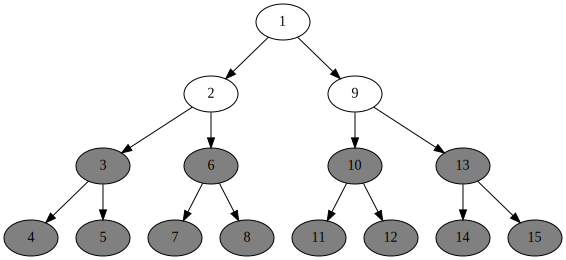

In [8]:
weights = np.ones((15,))
for i in [2,5,9,12]:
    weights[i] = 100  
# weights[8] = 0.1
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])

rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)
spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='btree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='btree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [2,5,9,12,3,4,6,7,10,11,13,14]:
    dot.node(f'{i}', f'{i}', style='filled', fillcolor='grey')
for i in range(15):
    dot.node(f'{i}', f'{i+1}')    
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree_rml2', directory='./graphviz', cleanup=True, format='pdf')
dot

## Pattern 5

G_0: [0, 1, 8, 2, 5, 9, 12, 3, 4, 6, 7, 10, 11, 13, 14] penalty: 0.1
G_1: [1, 2, 5, 3, 4, 6, 7] penalty: 10.0
G_2: [2, 3, 4] penalty: 0.1
G_3: [3] penalty: 0.1
G_4: [4] penalty: 0.1
G_5: [5, 6, 7] penalty: 0.1
G_6: [6] penalty: 0.1
G_7: [7] penalty: 0.1
G_8: [8, 9, 12, 10, 11, 13, 14] penalty: 10.0
G_9: [9, 10, 11] penalty: 0.1
G_10: [10] penalty: 0.1
G_11: [11] penalty: 0.1
G_12: [12, 13, 14] penalty: 0.1
G_13: [13] penalty: 0.1
G_14: [14] penalty: 0.1
=== spams sol ===
spams_sol [[1.33037802 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]] 
spams_nnz 1 spams_nz 14
=== my sol===
mysol [[1.33402466 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]] 
mynnz 1 mynz 14
sol diff 0.00364664086901878


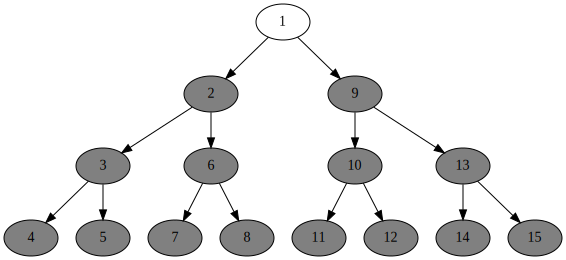

In [9]:
weights = np.ones((15,))
for i in [1,8]:
    weights[i] = 100  
# weights[8] = 0.1
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])

rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)
spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='btree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='btree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)    

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [1,8,2,5,9,12,3,4,6,7,10,11,13,14]:
    dot.node(f'{i}', f'{i}', style='filled', fillcolor='grey')
for i in range(15):
    dot.node(f'{i}', f'{i+1}')
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='btree_rml1', directory='./graphviz', cleanup=True, format='pdf')
dot

# Octree

In [19]:
p = 51
np.random.seed(0)
xk = np.random.randn(p, 1)
dk = np.random.randn(p, 1)
alphak = 1.0
               
# tree
nodes_list=[[i*3, i*3+1, i*3+2] for i in range(17)]
nodes_relation_dict={0:[1]+[i for i in range(10,17)], 
                     1:[i for i in range(2,10)]}   
penalty = 0.1                     

## full tree


G_0: [0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 0.7141428428542851
G_1: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 0.5196152422706632
G_2: [6, 7, 8] penalty: 0.17320508075688773
G_3: [9, 10, 11] penalty: 0.17320508075688773
G_4: [12, 13, 14] penalty: 0.17320508075688773
G_5: [15, 16, 17] penalty: 0.17320508075688773
G_6: [18, 19, 20] penalty: 0.17320508075688773
G_7: [21, 22, 23] penalty: 0.17320508075688773
G_8: [24, 25, 26] penalty: 0.17320508075688773
G_9: [27, 28, 29] penalty: 0.17320508075688773
G_10: [30, 31, 32] penalty: 0.17320508075688773
G_11: [33, 34, 35] penalty: 0.17320508075688773
G_12: [36, 37, 38] penalty: 0.17320508075688773
G_13: [39, 40, 41] penalty: 0.17320508075688773
G_14: [42, 43, 44] penalty: 0.17320508075688773
G_15: [45, 46, 47] penalt

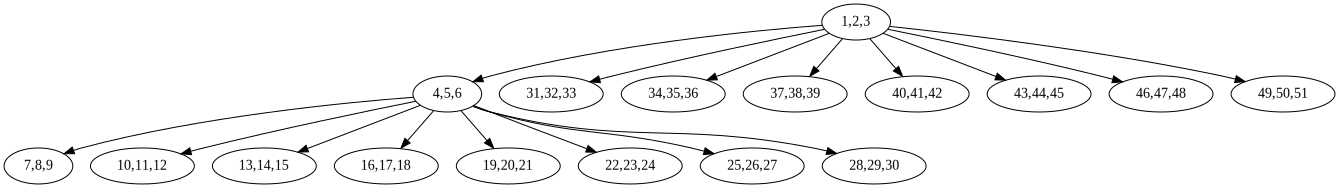

In [24]:
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=None)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])
dot.attr(bgcolor='transparent', ratio="compress")
for i in range(17):
    dot.node(f'{i}', f'{i*3+1},{i*3+2},{i*3+3}')
dot.render(filename='octree', directory='./graphviz', cleanup=True, format='pdf')
dot

## Pattern 1

G_0: [0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 0.1
G_1: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 0.1
G_2: [6, 7, 8] penalty: 10.0
G_3: [9, 10, 11] penalty: 0.1
G_4: [12, 13, 14] penalty: 10.0
G_5: [15, 16, 17] penalty: 0.1
G_6: [18, 19, 20] penalty: 10.0
G_7: [21, 22, 23] penalty: 0.1
G_8: [24, 25, 26] penalty: 0.1
G_9: [27, 28, 29] penalty: 0.1
G_10: [30, 31, 32] penalty: 0.1
G_11: [33, 34, 35] penalty: 0.1
G_12: [36, 37, 38] penalty: 10.0
G_13: [39, 40, 41] penalty: 0.1
G_14: [42, 43, 44] penalty: 10.0
G_15: [45, 46, 47] penalty: 0.1
G_16: [48, 49, 50] penalty: 10.0
=== spams sol ===
spams_sol [[ 1.36202304  0.90095621  2.13565135  2.20960763  1.40150697 -1.01643938
   0.          0.          0.          1.01352061  0.47126306  2.12183898
   0.          0.

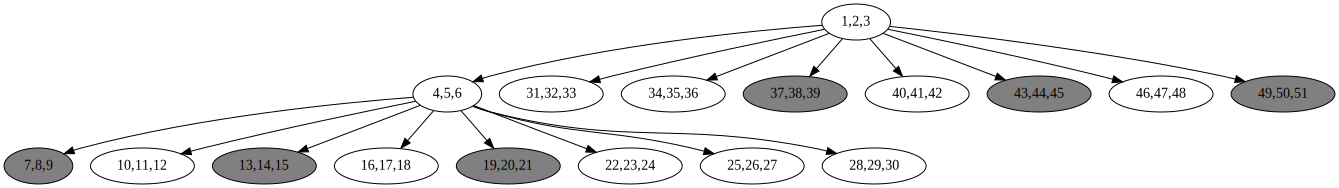

In [28]:
weights = np.ones((17,))
for i in [2,4,6,12,14,16]:
    weights[i] = 100  
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])

rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)
spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='octree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='octree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [2,4,6,12,14,16]:
    dot.node(f'{i}', style='filled', fillcolor='grey')
for i in range(17):
    dot.node(f'{i}', f'{i*3+1},{i*3+2},{i*3+3}')    
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='octree_rm6sub', directory='./graphviz', cleanup=True, format='pdf')
dot

## Pattern 2

G_0: [0, 1, 2, 3, 4, 5, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 0.1
G_1: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] penalty: 10.0
G_2: [6, 7, 8] penalty: 0.1
G_3: [9, 10, 11] penalty: 0.1
G_4: [12, 13, 14] penalty: 0.1
G_5: [15, 16, 17] penalty: 0.1
G_6: [18, 19, 20] penalty: 0.1
G_7: [21, 22, 23] penalty: 0.1
G_8: [24, 25, 26] penalty: 0.1
G_9: [27, 28, 29] penalty: 0.1
G_10: [30, 31, 32] penalty: 0.1
G_11: [33, 34, 35] penalty: 0.1
G_12: [36, 37, 38] penalty: 0.1
G_13: [39, 40, 41] penalty: 0.1
G_14: [42, 43, 44] penalty: 0.1
G_15: [45, 46, 47] penalty: 0.1
G_16: [48, 49, 50] penalty: 0.1
=== spams sol ===
spams_sol [[ 1.36060049  0.90001522  2.13342079  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         

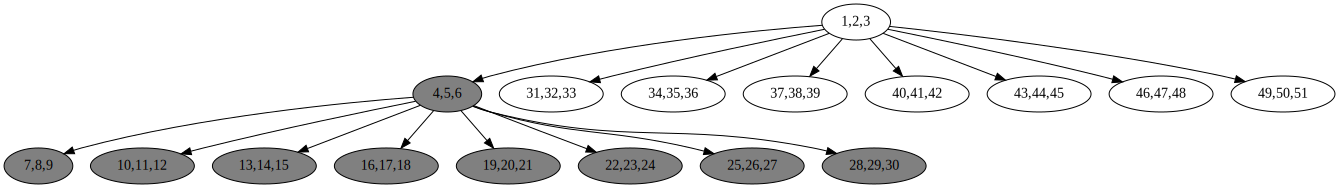

In [29]:
weights = np.ones((17,))
for i in [1]:
    weights[i] = 100  
groups, tree, dot = gen_tree(nodes_list, nodes_relation_dict, penalty=penalty, weights=weights)
for i,g in enumerate(groups):
    print(f"G_{i}:", g, "penalty:", tree['eta_g'][i])

rtree = TreeOG(groups, tree, penalty, weights=weights)
rnatog = NatOG(groups, penalty=penalty, config=config, weights=weights)
spams_sol, spams_nnz, spams_nz = rtree.compute_exact_proximal_gradient_update(xk, alphak, dk, compute_structure=True)
print("=== spams sol ===")
print('spams_sol', spams_sol.T, '\nspams_nnz', spams_nnz, 'spams_nz', spams_nz)


mysol, _ = rnatog.compute_inexact_proximal_gradient_update(xk, alphak, dk, y_init=None, stepsize_init=None, ipg_kwargs={'iteration':1, 'xref':xk})
rnatog.print_header(filename='octree_log.txt')
rnatog.print_iteration(epoch = 1, batch=1, filename='octree_log.txt')
mynnz, mynz = rnatog._get_group_structure(mysol)
print("=== my sol===")
print('mysol', mysol.T, '\nmynnz', mynnz, 'mynz', mynz)

print("sol diff", np.linalg.norm(mysol - spams_sol))

for i in [1,2,3,4,5,6,7,8,9]:
    dot.node(f'{i}', style='filled', fillcolor='grey')
for i in range(17):
    dot.node(f'{i}', f'{i*3+1},{i*3+2},{i*3+3}')
dot.attr(bgcolor='transparent', ratio="compress")
dot.render(filename='octree_rml2', directory='./graphviz', cleanup=True, format='pdf')
dot